In [1]:
import ipywidgets
from glob import glob
from os import walk
import os
import numpy as np
from atl_module.load_netcdf import get_beams,load_beam_array_ncds 
from atl_module import icesat_bathymetry
from atl_module.raster_interaction import query_raster
from atl_module.error_calc import calc_rms_error
    
from bokeh.io import output_notebook
from bokeh.palettes import Spectral5
from bokeh.plotting import figure, show
from bokeh.transform import factor_cmap
output_notebook()
TOOLS = "hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"

# TODO abstract the graph into smaller functions, then combine into one "evaluate transect" function that can be run as callback with the widgets


Loading BokehJS ...

In [2]:
# little weird but it works :)

# create emtpy globals to update
site_granules = ''
beam = ''
granchooser = ipywidgets.Select()
beamchooser = ipywidgets.Select()


In [3]:
outlist = list(walk('../data/test_sites'))
subdirlist = outlist[0][1]
sitechooser = ipywidgets.Select(options=subdirlist,description = 'Choose a test site')

In [4]:
# these callbacks call one other another
def list_netcdf_granules(foldername):
    granlist = list(glob(f'../data/test_sites/{foldername}/ATL03/*.nc'))
    global site_granules
    site_granules = granlist
    global granchooser
    granchooser =  ipywidgets.Select(options=granlist)
    print(foldername,'has been selected')
    ipywidgets.interact(set_granule_file,file=granchooser)
    return None

def set_granule_file(file):
    global chosen_granule
    chosen_granule = file
    beamlist = get_beams(chosen_granule)
    global beamchooser
    beamchooser = ipywidgets.Select(options=beamlist)
    print(f'Granule {chosen_granule} selected')
    ipywidgets.interact(set_chosen_beam,beamname=beamchooser)
    return None

def set_chosen_beam(beamname):
    global beam
    beam = beamname
    return None


In [5]:
ipywidgets.interact(list_netcdf_granules,foldername = sitechooser)


interactive(children=(Select(description='Choose a test site', options=('florida_keys', 'Martinique', 'NL', 'N…

<function __main__.list_netcdf_granules(foldername)>

In [27]:
beamdata = load_beam_array_ncds(chosen_granule,beam)
print(beamdata.dtype.metadata)
# convert the numpy array into a dataframe
raw_data = icesat_bathymetry.add_along_track_dist(beamdata)
points_after_filtering = icesat_bathymetry._filter_points(raw_data)

9652
{'data_end_utc': '2019-04-03T23:35:43.953478Z', 'data_start_utc': '2019-04-03T23:28:41.713668Z', 'end_rgt': '87', 'start_rgt': '87', 'Description': 'Each group contains the segments for one Ground Track. As ICESat-2 orbits the earth, sequential transmit pulses illuminate six ground tracks on the surface of the earth.  The track width is approximately 14m.  Each ground track is numbered, according to the laser spot number that generates a given ground track.  Ground tracks are numbered from the left to the right in the direction of spacecraft travel as: 1L, 1R in the left-most pair of beams; 2L, 2R for the center pair of beams; and 3L, 3R for the right-most pair of beams.', 'atlas_pce': 'pce2', 'atlas_beam_type': 'strong', 'groundtrack_id': 'gt2l', 'atmosphere_profile': 'profile_2', 'atlas_spot_number': '3', 'sc_orientation': 'Backward', 'ocean_high_conf_perc': 96.01318292751105}


In [28]:
raw_data_plot = figure(tools=TOOLS,sizing_mode='scale_width',height=200,title="Raw Photons on transect")
raw_data["oc_sig_conf"] = raw_data.oc_sig_conf.astype("str")
signal_conf_cmap = factor_cmap("oc_sig_conf",palette=Spectral5,factors=sorted(raw_data.oc_sig_conf.unique().astype("str")),)
raw_data_plot.scatter(
    source=raw_data,
    x="dist_or",
    y="Z_g",
    color=signal_conf_cmap,
    legend_field="oc_sig_conf",
)

show(raw_data_plot)

In [29]:
filtered_plot = figure(tools=TOOLS,sizing_mode='scale_width',height=200,title="Points After Filtering")

filtered_plot.scatter(source=raw_data,x='dist_or',y='Z_g',alpha=0.1)
filtered_plot.scatter(source=points_after_filtering,x='dist_or',y='Z_g',color='red',alpha = 0.5)
filtered_plot.line(source=points_after_filtering,x='dist_or',y='sea_level_interp',color='orange')
filtered_plot.line(source=points_after_filtering,x='dist_or',y='gebco_elev',color='blue')
show(filtered_plot)

In [30]:
bathy_df = icesat_bathymetry.add_rolling_kde(points_after_filtering,window=200)

thresholdval = bathy_df.kde_val.median()-0.5*bathy_df.kde_val.std()
print(thresholdval)
# thresholdval=0.0
bathy_df.loc[(bathy_df.kde_val < thresholdval),'z_kde'] = np.NaN

0.23935990242906668


In [31]:
kde_seafloor_plot = figure(tools=TOOLS,sizing_mode='scale_width',height=200,title="Assumed Seafloor Pre-correction")

kde_seafloor_plot.scatter(source=bathy_df,x='dist_or',y='Z_g',alpha=0.5)
kde_seafloor_plot.line(source=bathy_df,x='dist_or',y='z_kde',color='red')
# kde_seafloor_plot.line(source=bathy_df.eval('kde_val = kde_val*100'),x='dist_or',y='kde_val',color='red')
show(kde_seafloor_plot)

In [32]:
true_bathy = query_raster(bathy_df,src='../data/test_sites/Martinique/in-situ-dem/DONNEES/MNT_ANTS100m_HOMONIM_WGS84_PBMA_ZNEG.grd')
bathy_df = bathy_df.assign(fema_elev = true_bathy,error=bathy_df.z_kde-true_bathy)

In [33]:
calc_rms_error(bathy_df, ['fema_elev'])

{'fema_elev_error': 0.19295540591244495}

In [34]:
truth_comp_plot = figure(tools=TOOLS,sizing_mode='scale_width',height=200,title="Seafloor calculated from ICESat using KDE")

truth_comp_plot.line(source=bathy_df,x='dist_or',y='z_kde')
truth_comp_plot.line(source=bathy_df,x='dist_or',y='fema_elev',color='red')

show(truth_comp_plot)

<AxesSubplot:xlabel='fema_elev', ylabel='error'>

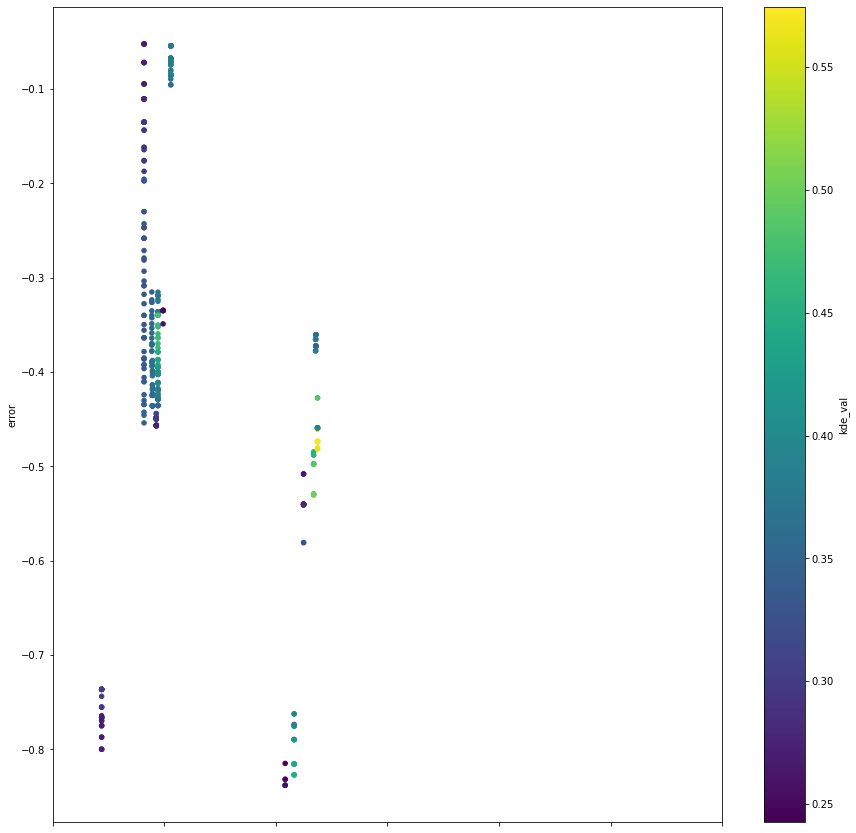

In [35]:
bathy_df.plot.scatter(x='fema_elev',y='error',xlim=[0,-12],figsize=(15,15),c='kde_val',cmap='viridis')

<AxesSubplot:xlabel='fema_elev', ylabel='z_kde'>

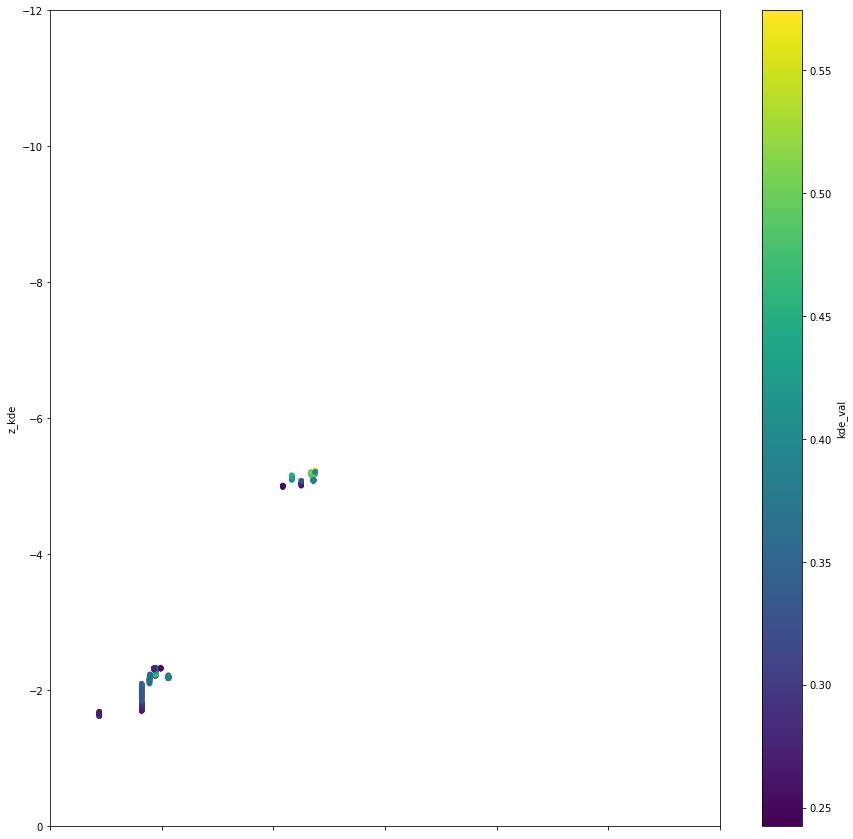

In [36]:
bathy_df.plot.scatter(x='fema_elev',y='z_kde',xlim=[0,-12],ylim=[0,-12],figsize=(15,15),c='kde_val',cmap='viridis')

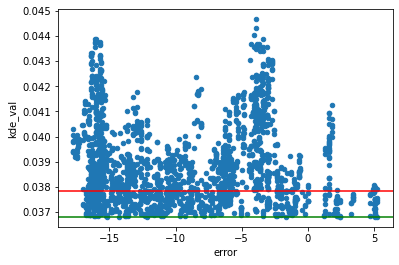

In [16]:
fig = bathy_df.plot.scatter(x='error',y='kde_val')
fig.axhline(bathy_df.kde_val.median(),color='red')
fig.axhline(bathy_df.kde_val.median()-0.5*bathy_df.kde_val.std(),color='green')